In [2]:
#getting libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter, StrMethodFormatter, PercentFormatter

C:\Users\Home\AppData\Local\Temp\ipykernel_4792\3304943887.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
#Storing vars

#color palette dict
palette = {
    'lendable_green': '#35C187',
    'light_orange': '#F2CF5B',
    'light_gray': '#636363',
    'gray_blue': '#3C6682',
    'pale_red': '#E78587'
}

In [ ]:
#loading data
#loans
loans_df = pd.read_csv("2a. LendyLender Loans.csv")
loans_df["begin_date"] = pd.to_datetime(loans_df["begin_date"], format='%m/%d/%y %H:%M')
loans_df["end_date"] = pd.to_datetime(loans_df["end_date"], format='%m/%d/%y %H:%M')
loans_df["tenor_months"] = ((loans_df["end_date"].dt.year)*12 + loans_df["end_date"].dt.month) - ((loans_df["begin_date"].dt.year)*12 + loans_df["begin_date"].dt.month)



#transaactions
transactions_df = pd.read_csv("2b. LendyLender Transactions.csv")
transactions_df["transaction_date"] = pd.to_datetime(transactions_df["transaction_date"], format='%m/%d/%y %H:%M')

#merging loans and transactions + data reduction
loans_transactions_df = pd.merge(loans_df, transactions_df, on="loan_id", how="left")
loans_transactions_df.drop(["currency_type", "interest_rate_period", "transaction_id"], axis=1, inplace=True)
loans_transactions_df = loans_transactions_df[["loan_id", "account_id", "asset", "principal", "begin_date", "end_date", "tenor_months", "interest_rate", "interest_type", "gross_book_value",  "transaction_date", "transaction_type", "transaction_amount"]]

### Loan Data Description

In [ ]:
loans_df.describe()

,loan_id,gross_book_value,principal,account_id,interest_rate,tenor_months
count,8.890000e+03,8.890000e+03,8.890000e+03,8.890000e+03,8890.000000,8890.000000
mean,4.205180e+07,2.354277e+05,1.904386e+05,5.785608e+06,55.467808,13.332958
std,8.337835e+07,3.366191e+05,2.640855e+05,1.932169e+07,48.890324,14.326718
min,7.262660e+05,1.700000e+01,1.500000e+01,7.041420e+05,0.000000,0.000000
25%,7.285132e+05,1.190000e+04,1.002500e+04,7.071750e+05,18.000000,1.000000
50%,7.307555e+05,5.500000e+04,5.000000e+04,7.122210e+05,20.000000,6.000000
75%,2.866085e+07,3.806478e+05,3.140000e+05,7.172120e+05,120.000000,25.000000
max,3.875095e+08,6.446592e+06,4.550000e+06,1.746793e+08,520.000000,92.000000


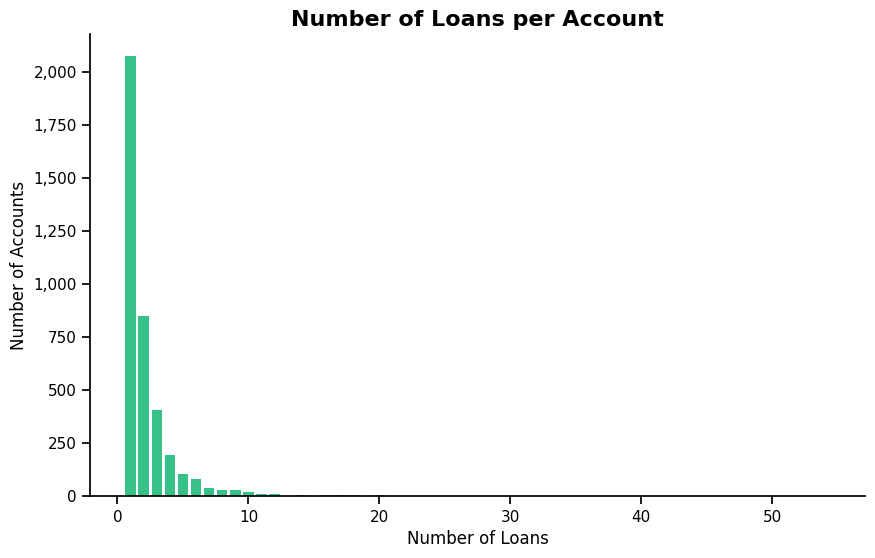

In [ ]:
loans_account_df = loans_df.copy()
loans_account_df = loans_account_df[['account_id', 'loan_id']]
# loans_account_df.groupby("account_id").size().reset_index(name='Count')
# loans_account_df

loan_count_per_account = loans_account_df.groupby('account_id')['loan_id'].nunique().reset_index()

# Count the number of accounts for each unique loan count
account_count_per_loan = loan_count_per_account.groupby('loan_id').size().reset_index(name='account_count')

plt.figure(figsize=(10, 6))
plt.bar(account_count_per_loan['loan_id'], account_count_per_loan['account_count'], color=palette['lendable_green'])

# Set title and labels
plt.title("Number of Loans per Account", fontsize=16, fontweight="bold")
plt.xlabel("Number of Loans")
plt.ylabel("Number of Accounts")

plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))

sns.despine()
# Display the plot
plt.show()

### Loan Distribution by Asset

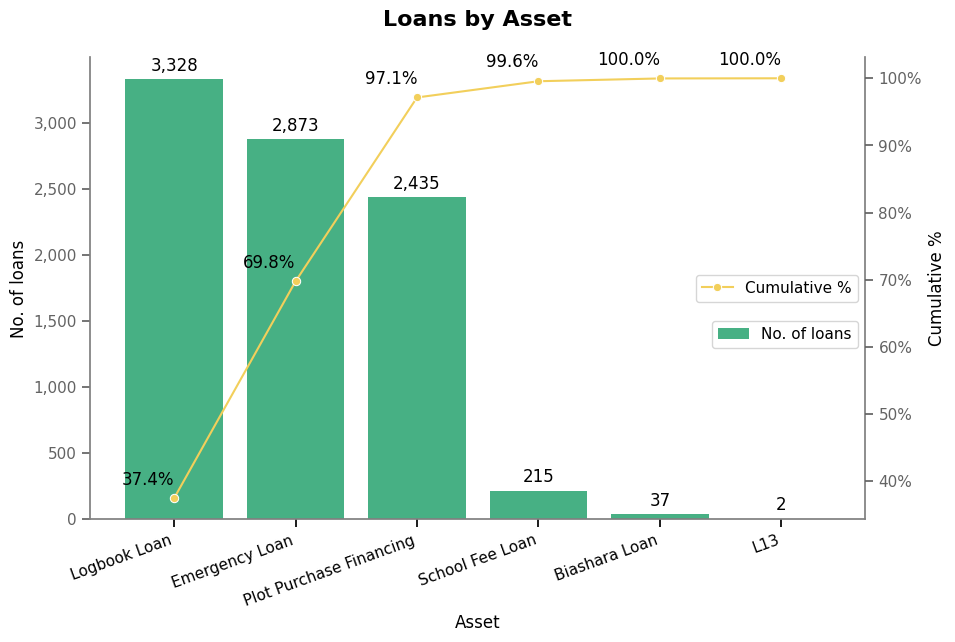

In [ ]:
loans_category_df = loans_df.groupby('asset').size().reset_index(name='Count')
loans_category_df["percentage"] = loans_category_df["Count"] / loans_category_df["Count"].sum()
loans_category_df = loans_category_df.sort_values(by="Count", ascending=False).reset_index(drop=True)
loans_category_df["cumulative_percentage"] = loans_category_df["percentage"].cumsum()

# Set Seaborn context for a more aesthetic appearance
sns.set_context("notebook")

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot bar chart for monthly revenue
sns.barplot(x='asset', y='Count', data=loans_category_df, color=palette['lendable_green'], ax=ax1, label='No. of loans')
ax1.set_xlabel('Asset')
ax1.set_ylabel('No. of loans')
ax1.tick_params('y', colors=palette['light_gray'])
ax1.set_xticklabels(loans_category_df['asset'], rotation=20, ha='right')
ax1.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot line chart for cumulative revenue
sns.lineplot(x='asset', y='cumulative_percentage', data=loans_category_df, color=palette['light_orange'], marker='o', ax=ax2, label='Cumulative %')
ax2.set_ylabel('Cumulative %')
ax2.tick_params('y', colors=palette['light_gray'])
ax2.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))

# Add legend
ax1.legend(loc='right', bbox_to_anchor=(1, 0.4))
ax2.legend(loc='right', bbox_to_anchor=(1, 0.5))

# Set title
plt.title('Loans by Asset', fontsize=16, fontweight="bold", y=1.05)

# Add data labels for bar chart
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f"{height:,.0f}", (p.get_x() + p.get_width() / 2., height),
                ha="center", va="center", xytext=(0, 10), textcoords="offset points")

# Add data labels for line chart
for x, y, label in zip(loans_category_df["asset"], loans_category_df["cumulative_percentage"], loans_category_df["cumulative_percentage"]):
    ax2.annotate(f"{label*100:.1f}%", (x, y), textcoords="offset points", xytext=(0, 10), ha='right')

# Remove borders
ax2.set_frame_on(False)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_color('gray')
ax1.spines['bottom'].set_color('gray')
ax1.spines['left'].set_color('gray')

plt.show()


### Loan by Interest Rate Type

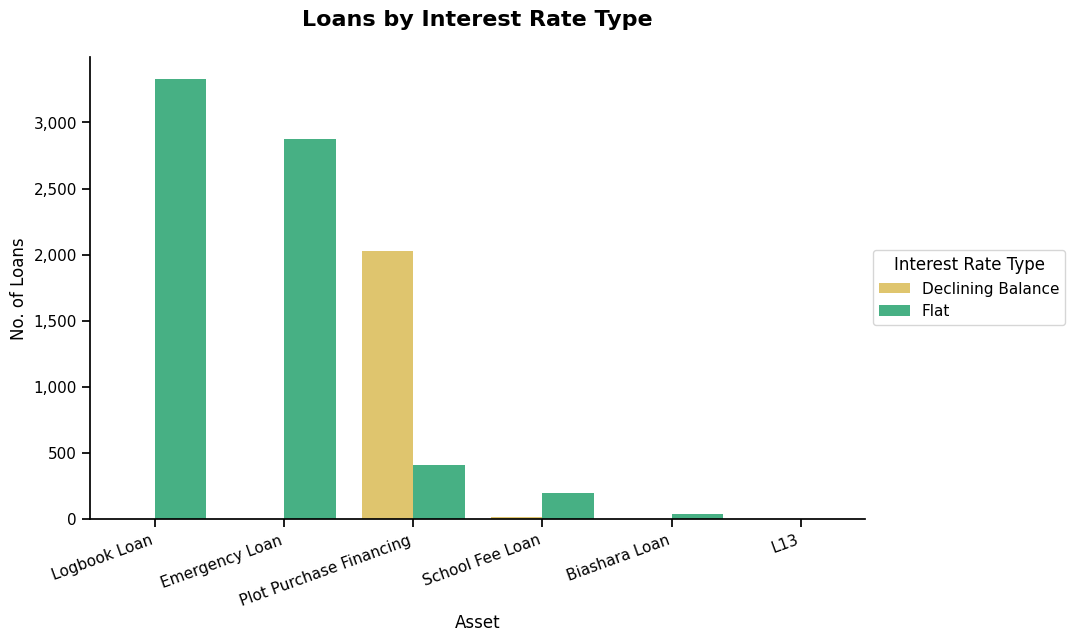

In [ ]:
sns.set_context("notebook")

# Create a stacked bar chart
plt.figure(figsize=(10, 6))

category_order = loans_df['asset'].value_counts().index

stacked_bar = sns.barplot(x="asset", y="loan_id", hue="interest_type", data=loans_df, estimator=lambda x: len(x),  
                          palette=[palette['light_orange'], palette['lendable_green']], order=category_order)


# Set title and labels
plt.title("Loans by Interest Rate Type", fontsize=16, fontweight="bold", y=1.05)

plt.ylabel("No. of Loans")
stacked_bar.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
plt.xlabel("Asset")
stacked_bar.set_xticklabels(loans_category_df['asset'], rotation=20, ha='right')

# for p in stacked_bar.patches:
#     width = p.get_width()
#     height = p.get_height()
#     x, y = p.get_xy() 
#     stacked_bar.annotate(f'{height:,.0f}', (x + width/2, y + height/2), ha='center', va='top', color='black')


sns.despine()

# Display the legend
plt.legend(title="Interest Rate Type", bbox_to_anchor=(1, 0.6), loc='upper left')

plt.show()

### Loan Distribution

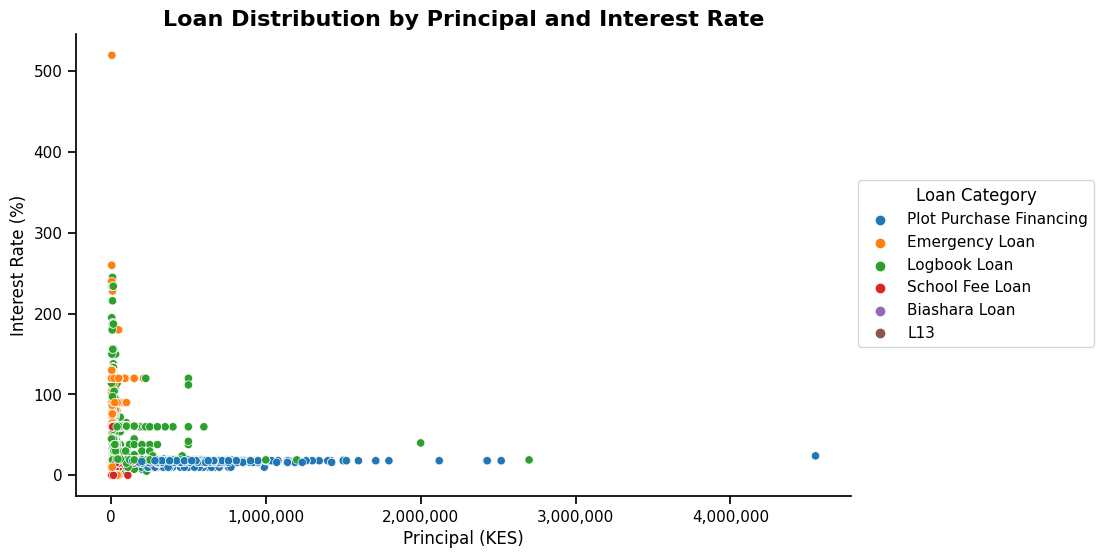

In [ ]:
sns.set_context("notebook")

# Create scatter plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x="principal", y="interest_rate", hue="asset", data=loans_df)

# Set title and labels
plt.title("Loan Distribution by Principal and Interest Rate", fontsize=16, fontweight="bold")
plt.xlabel("Principal (KES)")
plt.ylabel("Interest Rate (%)")
scatter_plot.xaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))

# Display the legend
plt.legend(title='Loan Category', bbox_to_anchor=(1, 0.7), loc='upper left')

sns.despine()

plt.show()


### Correlation between Principal and Tenor

In [ ]:
correlation = loans_df['principal'].corr(loans_df['tenor_months'])

print(f"Correlation between principal and tenor: {correlation}")

Correlation between principal and tenor: 0.7589358028695257


### Loans by Ending Date

<Figure size 640x480 with 0 Axes>

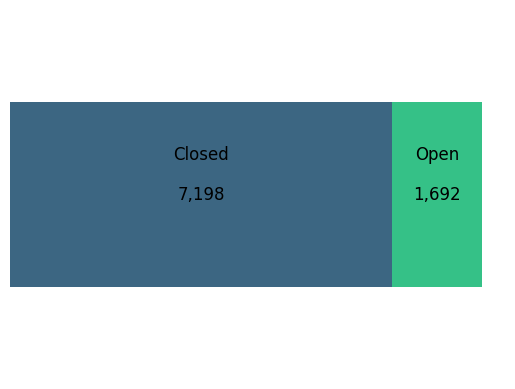

In [ ]:
# Copy the DataFrame to avoid modifying the original
current_date =max([loans_df['begin_date'].max(), transactions_df[transactions_df['transaction_type']== 'payment']['transaction_date'].max()])
dated_loans_df = loans_df.copy()

# Update the 'status' column based on the end_date
dated_loans_df['status'] = dated_loans_df['end_date'].apply(lambda x: 'Closed' if x < current_date else 'Open')
dated_loans_df['loan'] = 'loan'

# Counting occurrences of each combination of LoanType and LoanStatus
count_df = dated_loans_df.groupby(["loan", "status"]).size().unstack(fill_value=0)

# Creating the horizontal bar chart
plt.figure()


# Plotting each Status as a stacked bar within each Loan
ax = count_df.plot(kind="barh", stacked=True, color=[palette['gray_blue'], palette['lendable_green']], legend=False)

# Remove axes
ax.set_yticks([])
ax.set_xticks([])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.set_ylabel("")


# Add data labels showing the count of each status
for p, status in zip(ax.patches, count_df.columns):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width/2, y + height/2, '{:,.0f}'.format(width), ha='center', va='center', color='black')
    ax.text(x + width/2, y + height/1.4, status, ha='center', va='center', color='black')


# Display the plot
plt.show()

### Loan Portfolio Mix Evolution

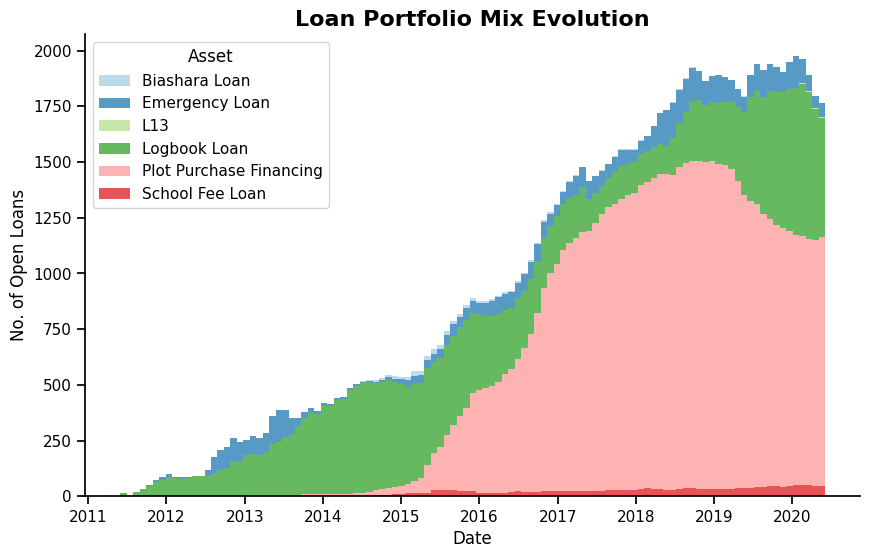

In [ ]:
earliest_loan_month = loans_df['begin_date'].min().to_period('M').start_time
current_month = current_date.to_period('M').end_time
date_range = pd.date_range(start=earliest_loan_month, end=current_month, freq='MS')
est_month_span = (current_month - earliest_loan_month)/30.4

# date_range
assets = loans_df['asset'].unique()
loans_df_copy = loans_df.copy()
loans_df_copy['begin_month'] = loans_df_copy['begin_date'].dt.to_period('M').dt.to_timestamp()
loans_df_copy['end_month'] = loans_df_copy['end_date'].dt.to_period('M').dt.to_timestamp()

date_range_df = pd.DataFrame({'date': date_range})
assets_df = pd.DataFrame({'asset': assets})

date_range_df['index_col'] = 1
assets_df['index_col'] = 1

date_assets_df = pd.merge(date_range_df, assets_df, on='index_col', how='left').drop('index_col', axis=1)
date_assets_loans_df = pd.merge(date_assets_df, loans_df_copy, how='left', on='asset')

date_assets_loans_df = date_assets_loans_df[(date_assets_loans_df['begin_month'] <= date_assets_loans_df['date']) & (date_assets_loans_df['end_month'] >= date_assets_loans_df['date'])]

date_assets_loans_df = date_assets_loans_df.groupby(['date', 'asset']).size().unstack(fill_value=0).reset_index()

# date_assets_loans_df

df_melted = date_assets_loans_df.melt(id_vars='date', var_name='Asset', value_name='count')

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_melted,
    multiple="stack",
    x="date",
    weights="count",  
    hue="Asset",
    palette='Paired',
    edgecolor='None',
    bins=109,
    )

# Set title and labels
plt.title("Loan Portfolio Mix Evolution", fontsize=16, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("No. of Open Loans")

# Display the legend
# plt.legend(title='Asset')

sns.despine()

# # Show the plot
# plt.show()


### Transaction Data Description

In [ ]:
transactions_df.head()

,transaction_id,loan_id,transaction_date,transaction_type,transaction_amount
0,9956177251,727161,2017-12-22 10:18:00,payment,27.38
1,9956177252,727161,2018-01-05 08:47:00,payment,61520.58
2,9956177253,727161,2018-01-06 08:34:00,payment,457.04
3,9956177254,727778,2017-12-23 11:20:00,payment,9200.00
4,9956177255,727778,2018-02-05 14:24:00,payment,9127.76


### Loan Repayment

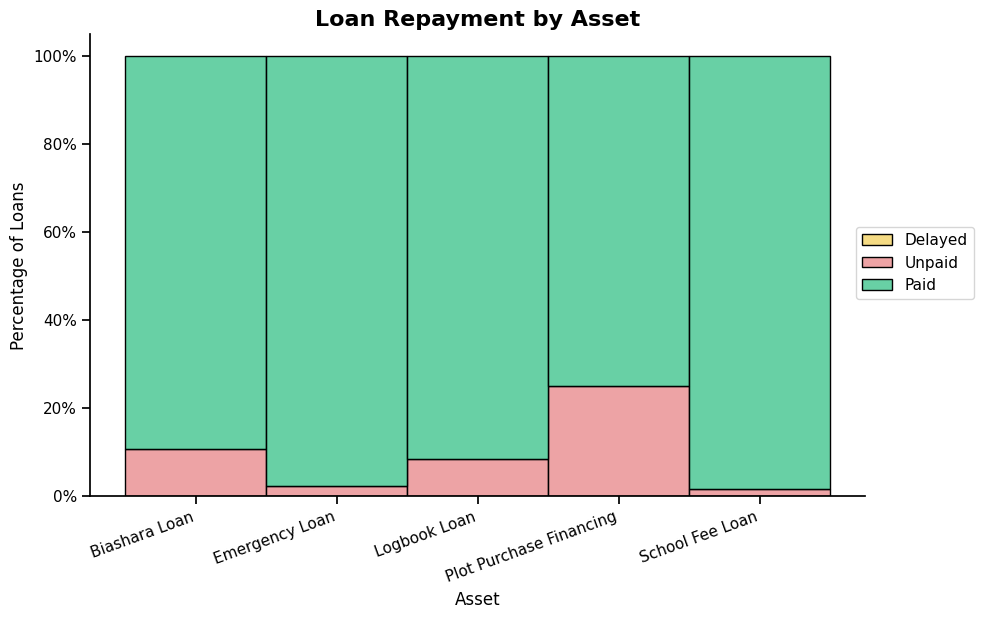

In [ ]:
agg_payments_df = transactions_df[transactions_df['transaction_type']=='payment'].copy()
agg_payments_df = agg_payments_df.groupby('loan_id')['transaction_amount'].sum()

agg_timed_payments_df = transactions_df[(transactions_df['transaction_type'] == 'payment') & (transactions_df['transaction_date'] <= current_date)].copy()
agg_timed_payments_df = agg_timed_payments_df.groupby('loan_id')['transaction_amount'].sum()

closed_loans_df = loans_df[loans_df['end_date'] < current_date].copy()

closed_loan_pmts_df = pd.merge(closed_loans_df, agg_payments_df, on='loan_id', how='left')
closed_loan_timed_pmts_df = pd.merge(closed_loans_df, agg_timed_payments_df, on='loan_id', how='left')

closed_loan_pmts_df['paid_off'] = closed_loan_pmts_df['gross_book_value'] <= closed_loan_pmts_df['transaction_amount']
closed_loan_timed_pmts_df['paid_off'] = closed_loan_timed_pmts_df['gross_book_value'] <= closed_loan_timed_pmts_df['transaction_amount']


untimed_percentage_df = closed_loan_pmts_df.groupby(['asset', 'paid_off']).size().unstack(fill_value=0).reset_index()
timed_percentage_df = closed_loan_timed_pmts_df.groupby(['asset', 'paid_off']).size().unstack(fill_value=0).reset_index()

percentage_df = pd.merge(timed_percentage_df, untimed_percentage_df, on='asset', how='left')
percentage_df['Delayed'] = percentage_df['True_x'] - percentage_df['True_y']
percentage_df.drop(['True_y', 'False_y'], axis = 1, inplace = True)
percentage_df.rename(columns = {'True_x': True, 'False_x': False}, inplace = True)


percentage_df['Total'] = percentage_df[False] + percentage_df[True] + percentage_df['Delayed']
percentage_df['percentage_paid_off'] = (percentage_df[True] / percentage_df['Total']) * 100
percentage_df['percentage_not_paid_off'] = (percentage_df[False] / percentage_df['Total']) * 100
percentage_df['percentage_delayed'] = (percentage_df['Delayed'] / percentage_df['Total']) * 100

plot_df = pd.melt(percentage_df, id_vars=['asset'], value_vars=['percentage_paid_off', 'percentage_not_paid_off', 'percentage_delayed'],
                  var_name='Payment_Status', value_name='Percentage')

plt.figure(figsize=(10, 6))

sns.histplot(
    data=plot_df,
    multiple="stack",
    x="asset",
    weights="Percentage",  
    hue="Payment_Status",
    palette=[palette['lendable_green'], palette['pale_red'], palette['light_orange']],
    )
# Format y-axis labels as percentages
formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y / 100))
plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks(rotation=20, ha='right')

plt.legend(loc='upper right', bbox_to_anchor=(1.15, 0.6), labels=['Delayed', 'Unpaid', 'Paid'])

# Add labels and title
plt.xlabel('Asset')
plt.ylabel('Percentage of Loans')
plt.title('Loan Repayment by Asset', fontweight='bold', size=16)

sns.despine()

# Show the plot
plt.show()

### Loan Performance

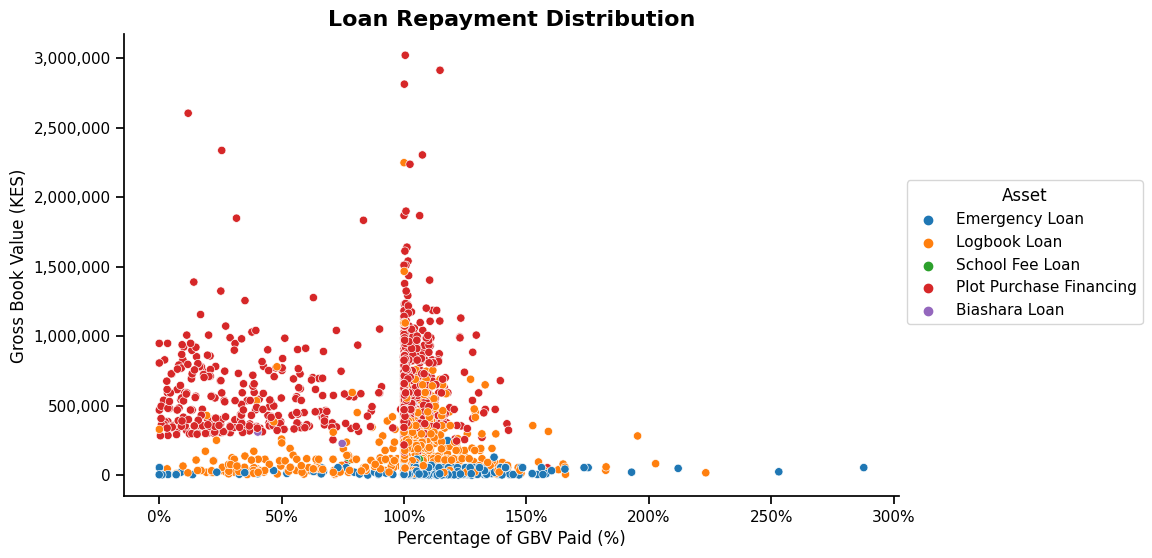

In [ ]:
loan_payments_df = closed_loan_timed_pmts_df.copy()
loan_payments_df.drop(['begin_date', 'end_date', 'account_id', 'currency_type', 'interest_rate_period', 'interest_type', 'paid_off'], axis = 1, inplace = True)
loan_payments_df['percentage_of_gbv_paid'] = loan_payments_df['transaction_amount'] / loan_payments_df['gross_book_value']
loan_payments_df

# Create scatter plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x="percentage_of_gbv_paid", y="gross_book_value", hue="asset", data=loan_payments_df)

# Set title and labels
plt.title("Loan Repayment Distribution", fontsize=16, fontweight="bold")
plt.xlabel("Percentage of GBV Paid (%)")
plt.ylabel("Gross Book Value (KES)")

# Format x-axis as percentage
scatter_plot.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

# Format y-axis with thousands separator and no decimal places
scatter_plot.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

# Display the legend
plt.legend(title='Asset', bbox_to_anchor=(1, 0.7), loc='upper left')

sns.despine()

plt.show()

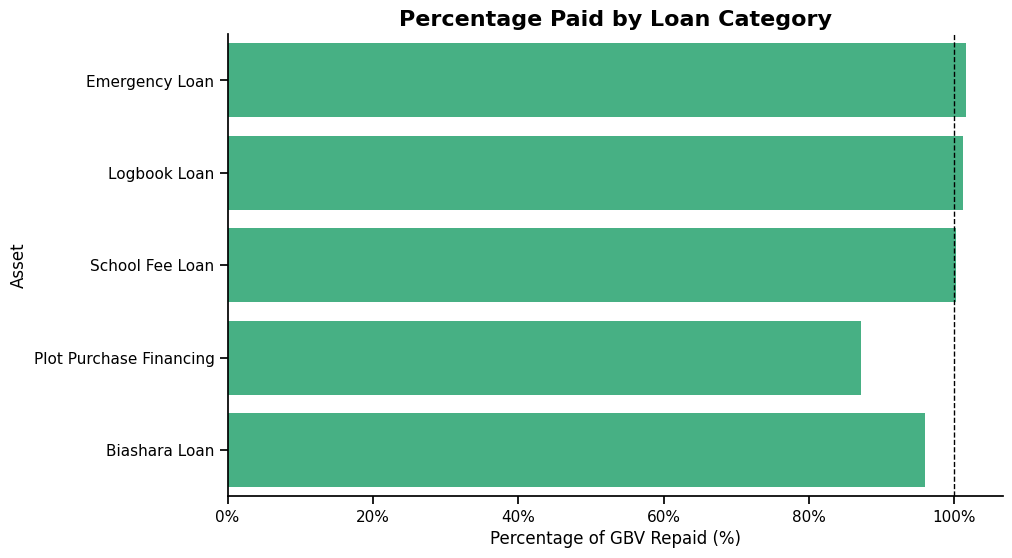

In [ ]:
agg_loan_payments_df = loan_payments_df.copy()
agg_loan_payments_df.groupby(['asset']).sum()
agg_loan_payments_df['percentage_of_gbv_paid'] = agg_loan_payments_df['transaction_amount'] / agg_loan_payments_df['gross_book_value']
agg_loan_payments_df

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='percentage_of_gbv_paid', y='asset', data=agg_loan_payments_df, color=palette['lendable_green'], errorbar=None)

# Set title and labels
plt.title("Percentage Paid by Loan Category", fontsize=16, fontweight="bold")
plt.xlabel("Percentage of GBV Repaid (%)")
plt.ylabel("Asset")

bar_plot.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

plt.axvline(x=1, color='black', linestyle='--', linewidth=1)

sns.despine()

plt.show()


### Rough work

In [ ]:
closed_loan_pmts_df[closed_loan_pmts_df['asset'] == 'Emergency Loan']

,loan_id,gross_book_value,asset,begin_date,principal,end_date,account_id,currency_type,interest_rate_period,interest_type,interest_rate,tenor_months,transaction_amount,paid_off
0,16810167,38500.0,Emergency Loan,2018-09-17 16:41:00,35000.0,2018-10-17,715177,KES,year,Flat,120.0,1,NaN,False
6,128821183,20000.0,Emergency Loan,2019-09-02 11:17:00,20000.0,2019-10-03,718633,KES,year,Flat,0.0,1,20000.00,True
7,139931325,23000.0,Emergency Loan,2019-09-25 15:42:00,23000.0,2019-10-26,718633,KES,year,Flat,0.0,1,23000.00,False
12,102226669,8800.0,Emergency Loan,2019-07-25 11:46:00,8000.0,2019-08-25,51241375,KES,year,Flat,120.0,1,8800.00,True
15,163357259,50000.0,Emergency Loan,2019-10-25 14:29:00,50000.0,2019-11-25,724300,KES,year,Flat,0.0,1,50000.00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7187,731458,5500.0,Emergency Loan,2013-01-09 15:14:00,5000.0,2013-02-08,704738,KES,year,Flat,130.0,1,5500.00,True
7188,736230,3960.0,Emergency Loan,2018-04-30 00:00:00,3600.0,2019-03-06,713603,KES,year,Flat,120.0,11,0.63,False
7191,730835,8800.0,Emergency Loan,2013-06-05 00:00:00,8000.0,2013-07-04,705281,KES,year,Flat,130.0,1,8800.00,True
7193,730841,5500.0,Emergency Loan,2013-07-10 00:00:00,5000.0,2013-08-07,705280,KES,year,Flat,130.0,1,5500.00,True


In [ ]:
#sampling
transactions_df[transactions_df['transaction_type'] == 'default'].sample()

,transaction_id,loan_id,transaction_date,transaction_type,transaction_amount
715987,9956957108,730738,2020-03-31 15:18:00,default,NaN


In [ ]:
#querying specific loans
loans_transactions_df[loans_transactions_df["loan_id"] == 163872491].sort_values(by=["transaction_date"])

,loan_id,account_id,asset,principal,begin_date,end_date,tenor_months,interest_rate,interest_type,gross_book_value,transaction_date,transaction_type,transaction_amount
484,163872491,715929,Logbook Loan,45000.0,2019-10-28 15:51:00,2020-01-27,3,60.833333,Flat,51750.0,2019-10-30 00:00:00,installment_due,-575.0
418,163872491,715929,Logbook Loan,45000.0,2019-10-28 15:51:00,2020-01-27,3,60.833333,Flat,51750.0,2019-10-30 10:50:00,payment,575.0
485,163872491,715929,Logbook Loan,45000.0,2019-10-28 15:51:00,2020-01-27,3,60.833333,Flat,51750.0,2019-10-31 00:00:00,installment_due,-575.0
419,163872491,715929,Logbook Loan,45000.0,2019-10-28 15:51:00,2020-01-27,3,60.833333,Flat,51750.0,2019-10-31 13:10:00,payment,575.0
486,163872491,715929,Logbook Loan,45000.0,2019-10-28 15:51:00,2020-01-27,3,60.833333,Flat,51750.0,2019-11-01 00:00:00,installment_due,-575.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,163872491,715929,Logbook Loan,45000.0,2019-10-28 15:51:00,2020-01-27,3,60.833333,Flat,51750.0,2020-02-11 00:00:00,installment_due,-575.0
570,163872491,715929,Logbook Loan,45000.0,2019-10-28 15:51:00,2020-01-27,3,60.833333,Flat,51750.0,2020-02-12 00:00:00,installment_due,-575.0
571,163872491,715929,Logbook Loan,45000.0,2019-10-28 15:51:00,2020-01-27,3,60.833333,Flat,51750.0,2020-02-13 00:00:00,installment_due,-575.0
572,163872491,715929,Logbook Loan,45000.0,2019-10-28 15:51:00,2020-01-27,3,60.833333,Flat,51750.0,2020-02-14 00:00:00,installment_due,-575.0


In [ ]:
#querying by interest_type
loans_transactions_df[loans_transactions_df["interest_type"] == "Declining Balance"].sort_values(by=["transaction_date"]).tail()

,loan_id,account_id,asset,principal,begin_date,end_date,tenor_months,interest_rate,interest_type,gross_book_value,transaction_date,transaction_type,transaction_amount
283488,232673227,707326,Logbook Loan,500000.0,2020-02-05 00:00:00,2023-06-15 00:00:00,40,15.0,Declining Balance,623976.00,2023-06-15,installment_due,-17332.9
358516,729841,713161,Plot Purchase Financing,4550000.0,2016-04-30 13:27:00,2023-12-16 00:00:00,92,24.0,Declining Balance,6446592.00,2023-12-16,installment_due,-110000.0
0,16305374,718695,Plot Purchase Financing,664000.0,2018-09-12 00:00:00,2021-09-20 00:00:00,36,18.0,Declining Balance,864186.87,NaT,NaN,NaN
619900,7582729,4623920,Plot Purchase Financing,759000.0,2018-07-09 15:27:00,2021-07-09 00:00:00,36,18.0,Declining Balance,987828.04,NaT,NaN,NaN
619901,11137191,8326798,Plot Purchase Financing,759000.0,2018-08-14 09:37:00,2021-08-14 03:04:00,36,18.0,Declining Balance,987828.04,NaT,NaN,NaN


In [ ]:
# loans_transactions_df[loans_transactions_df["loan_id"] == 163872491]["transaction_amount"].sum()

0.0

In [ ]:
loans_transactions_df.pivot_table(index="loan_id", columns="transaction_type", values="transaction_amount", aggfunc='sum')

transaction_type,default,fee,installment_due,payment
loan_id,,,,
726266,NaN,NaN,-25300.00,25300.00
726267,NaN,NaN,-33000.00,33000.00
726268,0.0,-46198.0,-358618.86,87661.78
726269,NaN,-5387.0,-354765.87,360152.87
726270,NaN,-3989.0,-17250.00,21239.00
...,...,...,...,...
387509528,NaN,NaN,-3500.00,NaN
387509529,NaN,NaN,-10000.00,NaN
387509530,NaN,NaN,-3000.00,NaN


In [ ]:
loans_df.describe()

,loan_id,gross_book_value,principal,account_id,interest_rate,tenor_months
count,8.890000e+03,8.890000e+03,8.890000e+03,8.890000e+03,8890.000000,8890.000000
mean,4.205180e+07,2.354277e+05,1.904386e+05,5.785608e+06,55.467808,13.332958
std,8.337835e+07,3.366191e+05,2.640855e+05,1.932169e+07,48.890324,14.326718
min,7.262660e+05,1.700000e+01,1.500000e+01,7.041420e+05,0.000000,0.000000
25%,7.285132e+05,1.190000e+04,1.002500e+04,7.071750e+05,18.000000,1.000000
50%,7.307555e+05,5.500000e+04,5.000000e+04,7.122210e+05,20.000000,6.000000
75%,2.866085e+07,3.806478e+05,3.140000e+05,7.172120e+05,120.000000,25.000000
max,3.875095e+08,6.446592e+06,4.550000e+06,1.746793e+08,520.000000,92.000000


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6f93a14c-d2da-4938-bc5c-540d1344deab' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>